In [2]:
import pandas as pd
import numpy as np
import re
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.models import Model
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import os

## Environment variables

In [63]:
RESIZE_IMAGE = 224
CHANNELS = 3

IMAGE_SHAPE = (
    RESIZE_IMAGE,
    RESIZE_IMAGE,
    CHANNELS
)

RESULT_CSV = 'flickr30k_dataset/results.csv'
DATASET_PATH_DEFAULT = 'flickr30k_dataset/flickr30k_images'
MAX_LENGTH=20

In [64]:
RESULT_CSV = 'flickr30k_dataset/results.csv'
df = pd.read_csv(
    RESULT_CSV, 
    delimiter='|',
    header=0,
    names=[
        'image_label',
        'number_comment',
        'comment'
    ]
)

df.head()

,image_label,number_comment,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [30]:
id = df['image_label'].values
print('ID IMAGES SHAPE ', id.shape)

comment = df['comment']
print('COMMENT SHAPE', comment.shape)

ID IMAGES SHAPE  (158915,)
COMMENT SHAPE (158915,)


In [28]:
def sentence_cleaning(sentence):
    try:
        sentence = sentence.lower()
        sentence = re.sub('[^a-z]+', ' ', sentence)
        sentence = sentence.split()
        sentence = [word for word in sentence if len(word) > 1]
        sentence = ' '.join(sentence)
        return(sentence)
    except:
        return(sentence_cleaning('A dog runs a cross the grass .'))

In [31]:
vocab_dict = {}

for i in range(comment.shape[0]):
    if id[i] not in vocab_dict:
        vocab_dict[id[i]] = []
    sen = sentence_cleaning(comment[i])
    vocab_dict[id[i]].append(sen)
    
len(vocab_dict)

31783

In [32]:
# print(vocab_dict[''])
LAST_IMAGE = list(vocab_dict.keys())[-1]
print(LAST_IMAGE)
print(vocab_dict[LAST_IMAGE])

998845445.jpg
['man in shorts and hawaiian shirt leans over the rail of pilot boat with fog and mountains in the background', 'young man hanging over the side of boat which is in like with fog rolling over hill behind it', 'man is leaning off of the side of blue and white boat as it sits in body of water', 'man riding small boat in harbor with fog and mountains in the background', 'man on moored blue and white boat with hills and mist in the background']


In [33]:
# GET WORD FROM DICT
word_dict = {}

for _, descriptions in vocab_dict.items():
    for description in descriptions:
        for word in description.split():
            if word not in word_dict:
                word_dict[word] = 1
            else:
                word_dict[word] += 1
                
print(len(word_dict))

18054


In [34]:
final_words=[x for x in word_dict if word_dict[x]>10]

print(len(final_words))

for i in vocab_dict:
    for j in range(len(vocab_dict[i])):
        vocab_dict[i][j]='startseq ' + vocab_dict[i][j]+' endseq'

s=1
word_to_idx={}
idx_to_word={}
for i in final_words:
    word_to_idx[i]=s
    idx_to_word[s]=i
    s+=1

print(len(word_to_idx))

### Two Special words
word_to_idx['startseq']=5119
word_to_idx['endseq']=5120
idx_to_word[5119]='startseq'
idx_to_word[5120]='endseq'

print(len(word_to_idx))

vocab_size=len(word_to_idx)+1 # adding one for 0 because that will also in our vector

max_len=20

5118
5118
5120


## Image data preprocessing

In [56]:
model = ResNet50(
    weights='imagenet', 
    input_shape=IMAGE_SHAPE
)

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [57]:
new_model=Model(model.input,model.layers[-2].output)
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [12]:
def preprocess_img(path):
    img = image.load_img(
        path,
        target_size=IMAGE_SHAPE
    )
    img = image.img_to_array(img)
    img = img.reshape(
        1,
        RESIZE_IMAGE,
        RESIZE_IMAGE,
        CHANNELS
    )
    return img

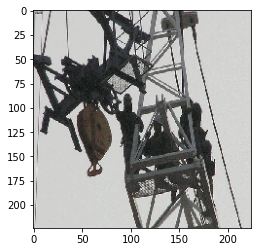

In [13]:
img=preprocess_img(f'{DATASET_PATH_DEFAULT}/10002456.jpg')

plt.imshow(img[0].astype('uint8'))

In [14]:
def encode_img(path):
    img = preprocess_img(path)
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [15]:
encode_img_dict = {}
s=0
for current_img in vocab_dict:
    path = f'{DATASET_PATH_DEFAULT}/{current_img}'
    encode_img_dict[current_img] = encode_img(path)
    s+=1
    
    if s % 100 == 0:
        print(s)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [18]:
np.save('encoded_img_dic.npy',encode_img_dict)

In [19]:
!ls -l --b=M  ./encoded_img_dic.npy | cut -d " " -f5

251M


In [20]:
!echo "hello"

hello


## Data Generator

In [49]:
def data_generator(train_description,vocab_size,word_to_idx,encoded_img_dic,max_len,batch_size):
    X1,X2,y=[],[],[]
    n=0
    while True:
        for key,desc_list in train_description.items():
            n+=1
            encoding_of_photo=encoded_img_dic[key]
            for desc in desc_list:
                seq=[word_to_idx[i] for i in desc.split() if i in word_to_idx]
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]
                    
                    
                    X1.append(encoding_of_photo)
                    X2.append(xi)
                    y.append(yi)
                if n==batch_size:
                    yield [np.array(X1),np.array(X2)],np.array(y)
                    X1,X2,y=[],[],[]
                    n=0

In [23]:
# with open('glove.6B.50d.txt',encoding='utf8') as f:
#     glove_data=f.read()

# len(glove_data)

# type(glove_data)

# glove_data=glove_data.split('\n')

# type(glove_data)

# len(glove_data)

# glove_data=glove_data[:-1]

# len(glove_data)

# glove_data[0].split()[0]

# embedding_index={}
# for line in glove_data:
#     line=line.split()
#     word=line[0]
#     embeding=np.array(line[1:],dtype='float')
#     embedding_index[word]=embeding
    

# len(embedding_index)

# embedding_index['the'].shape

# def get_embedding_matrix():
#     dim=50
#     matrix=np.zeros((vocab_size,dim))
#     for word,number in word_to_idx.items():
#         embedding_vector=embedding_index.get(word)
#         if embedding_vector is not None:
#             matrix[word_to_idx[word]]=embedding_vector
#     return matrix
    

# embedding_matrix=get_embedding_matrix()

# len(embedding_matrix)

# embedding_matrix[word_to_idx['the']]

# np.save('embedding_matrix.npy', embedding_matrix)

## load variables

In [25]:
embedding_matrix=np.load('embedding_matrix.npy')
encoded_img_dict=np.load('encoded_img_dic.npy', allow_pickle=True)
encoded_img_dict=dict(enumerate(encoded_img_dict.flatten(), 1))[1] # transform it array to dict!

In [27]:
encoded_img_dict['1000092795.jpg'].shape

(2048,)

## Model Architect and training

In [35]:
vocab_size

5121

In [38]:
## This is input for images
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)

In [39]:
input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [40]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

In [41]:
actual_model=Model(inputs=[input_img_features,input_captions],outputs=outputs)
actual_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 50)       256050      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
______________________________________________________________________________________________

In [43]:
actual_model.layers[2].set_weights([embedding_matrix])
actual_model.layers[2].trainable=False

In [44]:
actual_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [46]:
epochs=15
batch_size=3
steps=len(vocab_dict)//batch_size

In [51]:
def train():
    for i in range(epochs):
        generator=data_generator(
            vocab_dict,
            vocab_size,
            word_to_idx,
            encoded_img_dict,
            max_len,
            batch_size
        )
        actual_model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        actual_model.save('./models/model'+str(i)+'.h5')

In [52]:
train()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


    1/10594 [..............................] - ETA: 4:08 - loss: 3.7516

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


10594/10594 [==============================] - 203s 19ms/step - loss: 3.5658


In [53]:
def predict_caption(img):
    img=img.reshape(1,224,224,3)
    img=preprocess_input(img)
    feature_vector=new_model.predict(img)
    feature_vector=feature_vector.reshape((1,2048,1))
    in_text='startseq'
    for i in range(max_len):
        seq=[word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        seq=pad_sequences([seq],maxlen=max_len,padding='post')
        y_pred=actual_model.predict([feature_vector,seq])
        y_pred=y_pred.argmax()
        word=idx_to_word[y_pred]
        in_text+=' '+word
        
        if word=='endseq':
            break
    final_caption=in_text.split()[1:-1]
    final_caption=' '.join(final_caption)
    return final_caption

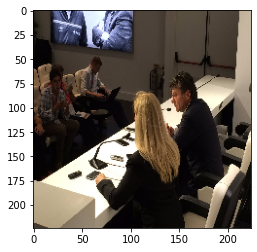

man in white shirt and black pants is sitting at table with an open table


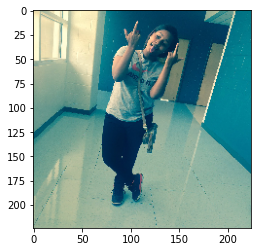

young boy is sitting on the floor with his eyes closed


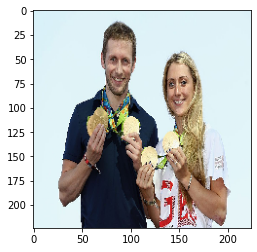

man in black shirt and black pants is sitting on the floor with his hand on his head


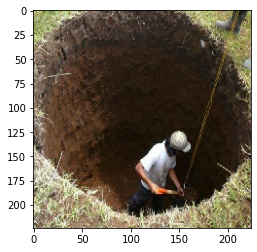

man in blue shirt is sitting on the ground with his hand on his head


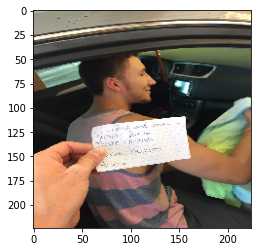

man in white shirt is sitting on couch with his hand on his lap


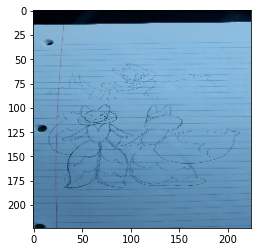

man in blue shirt is standing in front of building


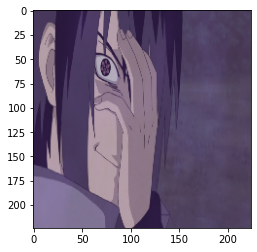

man in blue shirt is standing in front of building


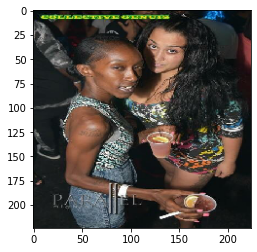

man in black shirt and black pants is sitting on the floor with his hand on his head


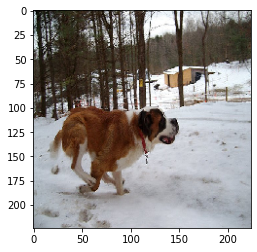

two dogs are playing in the grass


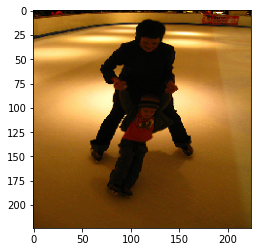

man in blue shirt is sitting on the ground with his hand on his head


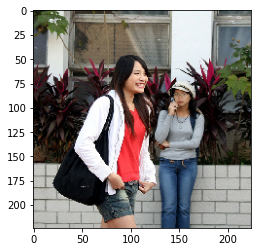

man in black shirt and jeans is standing in front of building


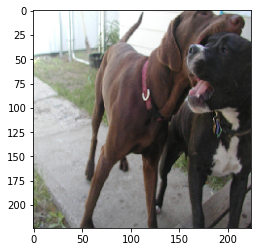

two dogs are playing in the grass


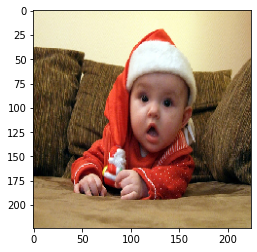

man in blue shirt is sitting on the floor with his hand on his head


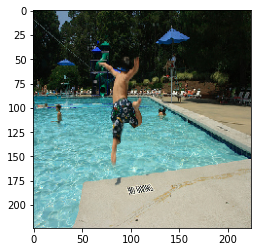

two men are playing soccer on the beach


In [82]:
for image_filename in os.listdir('./images_test'):
    img=image.load_img(f'images_test/{image_filename}',target_size=(224,224,3))
    img=image.img_to_array(img)
    plt.imshow(img/255)
    plt.show()
    print(predict_caption(img))

In [ ]:
predict_caption(img)

## Text sentiment analysis

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import operator
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [64]:
df_imdb = pd.read_csv('imdb_dataset.csv')
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [65]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [66]:
df_imdb["sentiment"].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [67]:
df_imdb['review'].iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [68]:
def cleanHtml(review):
    cleanreg = re.compile('<.*?>')
    cleantxt = re.sub(cleanreg, ' ', review)
    return cleantxt

df_imdb['review'] = df_imdb['review'].apply(cleanHtml)
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming t...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [69]:
df_imdb['sentiment_transform'] = df_imdb['sentiment'].apply(
    lambda x: 1 if x == 'positive' else 0
)

stop = set(stopwords.words("english"))
df_imdb['review'] = df_imdb['review'].apply(lambda x: ' '.join(
    [word for word in x.split() if word.lower() not in (stop)]
))

df_imdb.head()

,review,sentiment,sentiment_transform
0,One reviewers mentioned watching 1 Oz episode ...,positive,1
1,wonderful little production. filming technique...,positive,1
2,thought wonderful way spend time hot summer we...,positive,1
3,Basically there's family little boy (Jake) thi...,negative,0
4,"Petter Mattei's ""Love Time Money"" visually stu...",positive,1


In [70]:
df_imdb['review'].iloc[0]

"One reviewers mentioned watching 1 Oz episode hooked. right, exactly happened me. first thing struck Oz brutality unflinching scenes violence, set right word GO. Trust me, show faint hearted timid. show pulls punches regards drugs, sex violence. hardcore, classic use word. called OZ nickname given Oswald Maximum Security State Penitentary. focuses mainly Emerald City, experimental section prison cells glass fronts face inwards, privacy high agenda. Em City home many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish more....so scuffles, death stares, dodgy dealings shady agreements never far away. would say main appeal show due fact goes shows dare. Forget pretty pictures painted mainstream audiences, forget charm, forget romance...OZ mess around. first episode ever saw struck nasty surreal, say ready it, watched more, developed taste Oz, got accustomed high levels graphic violence. violence, injustice (crooked guards who'll sold nickel, inmates who'll kill order get awa

In [71]:
X = df_imdb.review
Y = df_imdb.sentiment_transform

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, 
    Y, 
    test_size = 0.15
)

In [73]:
# v_count_vectorize = CountVectorizer()
v_count_vectorize = TfidfVectorizer(sublinear_tf=True, max_df=0.5)

X_train_count = v_count_vectorize.fit_transform(X_train.values)

In [74]:
model_naive_bayes = MultinomialNB()

### time fit and score and another metrics during the cross validation

In [75]:
FOLDS = 5
results_cross_validate = cross_validate(
    model_naive_bayes, 
    X_train_count, 
    Y_train, 
    cv=FOLDS, 
    scoring=['accuracy']
)

print(results_cross_validate)

{'fit_time': array([0.05237532, 0.0483489 , 0.04688668, 0.04791713, 0.0486598 ]), 'score_time': array([0.0069387 , 0.00691366, 0.00696754, 0.00700021, 0.00699282]), 'test_accuracy': array([0.86458824, 0.86647059, 0.87282353, 0.86658824, 0.86894118])}


### diferent scores for different classes

In [76]:
FOLDS = 5
results_cross_validate = cross_val_score(
    model_naive_bayes, 
    X_train_count, 
    Y_train, 
    cv=FOLDS,
    scoring="f1_macro"
)

print("F1-macros:", results_cross_validate)
print("F1-macros:", np.mean(results_cross_validate), "+-", np.std(results_cross_validate))

F1-macros: [0.86454549 0.86642844 0.87279423 0.86654668 0.86887973]
F1-macros: 0.8678389126579603 +- 0.0028335298465626615


### verify test predict values result

In [77]:
X_test_count = v_count_vectorize.transform(X_test)

In [78]:
model_naive_bayes.fit(X_train_count, Y_train)

MultinomialNB()

In [79]:
Y_predict = model_naive_bayes.predict(X_test_count)
print(classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3735
           1       0.88      0.84      0.86      3765

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



[[3308  427]
 [ 591 3174]]


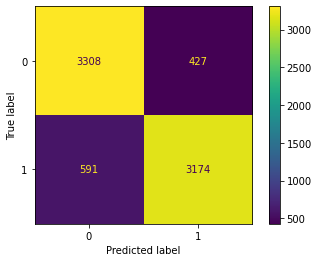

In [80]:
disp = plot_confusion_matrix(
    model_naive_bayes, 
    X_test_count, 
    Y_test
)
print(disp.confusion_matrix)

plt.show();

In [81]:
test_text = v_count_vectorize.transform(['it was amazing'])
model_naive_bayes.predict(test_text)

array([1])